<a href="https://colab.research.google.com/github/ALMerrill/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ALMerrill/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

* Watch tutorial

**DONE:**

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available()

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

* CrossEntropyLoss 
* Conv2D

**DONE:**

* Conv2D
___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**
* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform

**DONE:**



In [0]:
def Xe(data):
  mu = 0
  sigma = 1 / len(data[0])
  np.random.normal(mu, sigma, (data.size()))
  

def orthogonal(data):
  pass

def uniform(data):
  if len(data.size()) > 1:
    data.uniform_(-1, 1)
  else:
    data.uniform_(0,0)
  

class Conv2d(nn.Module):
  def __init__(self, n_channels, out_channels, kernel_size, stride=1, 
               padding=0, dilation=1, groups=1, 
               bias=True, initialization=uniform):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    
    self.weight = Parameter(torch.Tensor(out_channels, 
                               n_channels,
                               *kernel_size))
    initialization(self.weight.data)
    
    self.bias = Parameter(torch.Tensor(out_channels))
    initialization(self.bias.data)
    
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, 
                    self.padding, self.dilation, self.groups)
  
def oneHotEncode(y):
  y = y.cpu().detach().numpy()
  y_onehot = np.zeros((y.size(0), 10))
  y_onehot[np.arange(y.shape[0]).astype(int), y] = 1

class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean'):
    super(CrossEntropyLoss, self).__init__()
  
  def forward(self, y_hat, y_truth):
    wrong_class_penalty = torch.log(torch.sum(torch.exp(y_hat), dim=1))
    n, classes = y_hat.size()
    # Make a mask to create the y-truth one-hot vectors
    mask = torch.zeros((n, classes))
    mask[np.arange(n), y_truth] = 1
    # Pointwise multiply the mask with the output probabilities
    true_class_preds = torch.sum(y_hat * mask.cuda(), dim=1)
    return torch.mean(-true_class_preds + wrong_class_penalty, dim=0)
    
#     maxes, _ = torch.max(y_hat, 1, keepdim=True) #Log sum x trick to prevent overflow
#     y_hat = y_hat - maxes
#     y_hat = torch.exp(y_hat)
#     y_hat = y_hat / torch.sum(y_hat, 1, keepdim=True)
#     y_hat = oneHotEncode(y_hat)
#     return -torch.sum((torch.mul(y_truth.float(), torch.log(y_hat).float()))) #actual cross entropy loss part after the trick
  


In [0]:
class ConvNetwork(nn.Module):
  def __init__(self, dataset):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = 10
    dim1 = 50
    dim2 = 25
    dim3 = 40
    image_size = (28,28)
    init = uniform
    self.net = nn.Sequential(
        Conv2d(c, dim1, (3,3), padding=(1,1), initialization=init),
        nn.ReLU(),
        Conv2d(dim1, dim2, (3,3), padding=(1,1), initialization=init),
        nn.ReLU(),
        Conv2d(dim2, dim3, (3,3), padding=(1,1), initialization=init),
        nn.ReLU(),
        Conv2d(dim3, output, (28,28), padding=(0,0), initialization=init)
    )
  
  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)

transform = transforms.ToTensor()
  
  
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(root, 
                                      train=train, 
                                      transform=transform, 
                                      download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y
  
  def __len__(self):
    return len(self.data)

In [0]:
  
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)
model = ConvNetwork(train_dataset)
model = model.cuda()
objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset,
                         batch_size=100,
                         pin_memory=True)
val_loader = DataLoader(val_dataset,
                       batch_size=100,
                       pin_memory=True)

data_loaders = {'train': train_loader, 'val': val_loader}

losses = []
validations = []
train_acc = []
val_acc = []


## Training

epoch: 0, loss: inf, accuracy: 0.150:   0%|          | 0/600 [00:00<?, ?it/s]

tensor(inf, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:   1%|          | 4/600 [00:04<14:33,  1.47s/it]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.160:   1%|▏         | 8/600 [00:04<07:20,  1.34it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.060:   2%|▏         | 13/600 [00:04<03:49,  2.55it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:   3%|▎         | 17/600 [00:04<02:06,  4.59it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:   4%|▎         | 21/600 [00:05<01:17,  7.51it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:   4%|▍         | 25/600 [00:05<00:52, 10.95it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.060:   5%|▍         | 29/600 [00:05<00:40, 14.09it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:   5%|▌         | 32/600 [00:05<00:36, 15.38it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:   6%|▌         | 37/600 [00:05<00:31, 17.67it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:   7%|▋         | 43/600 [00:06<00:29, 18.91it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:   8%|▊         | 47/600 [00:06<00:28, 19.45it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:   9%|▊         | 52/600 [00:06<00:27, 20.22it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  10%|▉         | 58/600 [00:06<00:26, 20.24it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:  10%|█         | 62/600 [00:07<00:26, 20.36it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  11%|█         | 67/600 [00:07<00:25, 20.59it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.150:  12%|█▏        | 73/600 [00:07<00:25, 20.48it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  13%|█▎        | 76/600 [00:07<00:25, 20.45it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  14%|█▎        | 82/600 [00:08<00:25, 20.34it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  14%|█▍        | 86/600 [00:08<00:25, 20.47it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  15%|█▌        | 91/600 [00:08<00:24, 20.79it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  16%|█▌        | 97/600 [00:08<00:24, 20.87it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  17%|█▋        | 100/600 [00:09<00:23, 20.86it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:  18%|█▊        | 105/600 [00:13<02:40,  3.09it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  18%|█▊        | 109/600 [00:13<01:31,  5.36it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  19%|█▉        | 113/600 [00:13<00:57,  8.42it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  20%|█▉        | 117/600 [00:13<00:40, 11.90it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  20%|██        | 121/600 [00:13<00:32, 14.87it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  21%|██        | 125/600 [00:14<00:28, 16.86it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  22%|██▏       | 129/600 [00:14<00:26, 18.00it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  22%|██▏       | 133/600 [00:14<00:25, 18.43it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  23%|██▎       | 136/600 [00:14<00:24, 18.86it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.060:  24%|██▎       | 142/600 [00:15<00:23, 19.32it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  24%|██▍       | 146/600 [00:15<00:23, 19.19it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.160:  25%|██▍       | 149/600 [00:15<00:23, 19.28it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  26%|██▌       | 155/600 [00:15<00:22, 19.61it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.030:  26%|██▋       | 159/600 [00:15<00:22, 19.57it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  27%|██▋       | 163/600 [00:16<00:22, 19.67it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.050:  28%|██▊       | 166/600 [00:16<00:22, 19.62it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  28%|██▊       | 171/600 [00:16<00:21, 19.70it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  29%|██▉       | 175/600 [00:16<00:21, 19.37it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  30%|██▉       | 179/600 [00:16<00:21, 19.56it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  30%|███       | 182/600 [00:17<00:21, 19.88it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  31%|███       | 187/600 [00:17<00:20, 19.83it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  32%|███▏      | 192/600 [00:17<00:20, 19.48it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  33%|███▎      | 196/600 [00:17<00:21, 19.21it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  34%|███▎      | 201/600 [00:18<00:20, 19.66it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  34%|███▍      | 205/600 [00:22<03:03,  2.15it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  35%|███▍      | 208/600 [00:22<02:13,  2.93it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  35%|███▌      | 212/600 [00:22<01:14,  5.17it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)

epoch: 0, loss: nan, accuracy: 0.100:  36%|███▌      | 216/600 [00:22<00:57,  6.67it/s]


tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  37%|███▋      | 222/600 [00:23<00:31, 11.91it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  38%|███▊      | 226/600 [00:23<00:25, 14.92it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)

epoch: 0, loss: nan, accuracy: 0.120:  38%|███▊      | 231/600 [00:23<00:21, 17.13it/s]


tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  39%|███▉      | 236/600 [00:23<00:19, 18.50it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  40%|███▉      | 239/600 [00:23<00:18, 19.08it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:  41%|████      | 245/600 [00:24<00:18, 19.69it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  42%|████▏     | 249/600 [00:24<00:17, 19.72it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  42%|████▏     | 253/600 [00:24<00:17, 19.75it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  43%|████▎     | 259/600 [00:24<00:16, 20.14it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  44%|████▍     | 263/600 [00:25<00:16, 20.19it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  45%|████▍     | 268/600 [00:25<00:16, 20.34it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:  46%|████▌     | 274/600 [00:25<00:15, 20.74it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  46%|████▋     | 278/600 [00:25<00:15, 20.82it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  47%|████▋     | 283/600 [00:26<00:15, 20.77it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  48%|████▊     | 289/600 [00:26<00:15, 20.43it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  49%|████▊     | 292/600 [00:26<00:15, 20.36it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  50%|████▉     | 298/600 [00:26<00:14, 20.39it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  50%|█████     | 301/600 [00:26<00:14, 20.32it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  51%|█████     | 304/600 [00:31<02:09,  2.29it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.160:  52%|█████▏    | 310/600 [00:31<00:53,  5.46it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  52%|█████▏    | 313/600 [00:31<00:40,  7.00it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:  53%|█████▎    | 319/600 [00:31<00:26, 10.58it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  54%|█████▍    | 323/600 [00:31<00:22, 12.45it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  55%|█████▍    | 328/600 [00:32<00:17, 15.44it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  56%|█████▌    | 334/600 [00:32<00:15, 17.73it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  56%|█████▋    | 338/600 [00:32<00:14, 18.48it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  57%|█████▋    | 343/600 [00:32<00:13, 19.64it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  58%|█████▊    | 349/600 [00:33<00:12, 20.22it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.160:  59%|█████▉    | 353/600 [00:33<00:12, 20.12it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  60%|█████▉    | 358/600 [00:33<00:12, 19.95it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  61%|██████    | 364/600 [00:33<00:11, 20.53it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  61%|██████▏   | 368/600 [00:34<00:11, 20.80it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  62%|██████▏   | 373/600 [00:34<00:10, 20.65it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  63%|██████▎   | 379/600 [00:34<00:10, 20.26it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  64%|██████▎   | 382/600 [00:34<00:10, 20.19it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  64%|██████▍   | 386/600 [00:35<00:10, 20.06it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.170:  65%|██████▌   | 391/600 [00:35<00:10, 20.12it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  66%|██████▌   | 397/600 [00:35<00:09, 20.52it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  67%|██████▋   | 400/600 [00:35<00:09, 20.24it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.160:  68%|██████▊   | 405/600 [00:39<01:02,  3.11it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  68%|██████▊   | 408/600 [00:39<00:45,  4.19it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.060:  69%|██████▉   | 414/600 [00:40<00:26,  7.09it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.050:  70%|██████▉   | 418/600 [00:40<00:20,  8.88it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.160:  70%|███████   | 423/600 [00:40<00:13, 12.69it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  72%|███████▏  | 429/600 [00:40<00:10, 15.92it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  72%|███████▏  | 433/600 [00:41<00:09, 17.13it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  73%|███████▎  | 438/600 [00:41<00:08, 18.99it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  74%|███████▍  | 444/600 [00:41<00:07, 19.87it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  75%|███████▍  | 448/600 [00:41<00:07, 19.98it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.050:  76%|███████▌  | 453/600 [00:42<00:07, 20.04it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:  76%|███████▋  | 459/600 [00:42<00:07, 20.06it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  77%|███████▋  | 463/600 [00:42<00:06, 20.21it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  78%|███████▊  | 468/600 [00:42<00:06, 20.42it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  79%|███████▉  | 474/600 [00:43<00:06, 20.62it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  80%|███████▉  | 478/600 [00:43<00:05, 20.70it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.150:  80%|████████  | 483/600 [00:43<00:05, 20.36it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  82%|████████▏ | 489/600 [00:43<00:05, 20.36it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)

epoch: 0, loss: nan, accuracy: 0.100:  82%|████████▏ | 492/600 [00:44<00:05, 20.63it/s]


tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.150:  83%|████████▎ | 498/600 [00:44<00:04, 20.77it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  84%|████████▎ | 501/600 [00:44<00:04, 20.82it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  84%|████████▍ | 504/600 [00:48<00:41,  2.30it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  85%|████████▌ | 510/600 [00:48<00:21,  4.20it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.110:  86%|████████▌ | 514/600 [00:48<00:15,  5.52it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  86%|████████▋ | 519/600 [00:49<00:09,  8.72it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.080:  87%|████████▋ | 524/600 [00:49<00:06, 12.31it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.050:  88%|████████▊ | 529/600 [00:49<00:04, 15.71it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  89%|████████▉ | 535/600 [00:49<00:03, 18.03it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  90%|████████▉ | 539/600 [00:50<00:03, 18.59it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  91%|█████████ | 544/600 [00:50<00:02, 19.64it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.060:  92%|█████████▏| 550/600 [00:50<00:02, 20.19it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.150:  92%|█████████▏| 554/600 [00:50<00:02, 20.36it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.130:  93%|█████████▎| 559/600 [00:51<00:02, 20.33it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  94%|█████████▍| 565/600 [00:51<00:01, 20.49it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.090:  95%|█████████▍| 569/600 [00:51<00:01, 20.53it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.140:  96%|█████████▌| 574/600 [00:51<00:01, 20.48it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  97%|█████████▋| 580/600 [00:52<00:00, 20.57it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.120:  97%|█████████▋| 584/600 [00:52<00:00, 20.43it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.070:  98%|█████████▊| 589/600 [00:52<00:00, 20.24it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


epoch: 0, loss: nan, accuracy: 0.100:  99%|█████████▉| 595/600 [00:52<00:00, 20.61it/s]

tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)
tensor(nan, device='cuda:0', grad_fn=<MeanBackward2>)


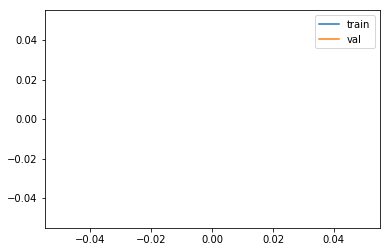

In [9]:
EPOCHS = 1



for epoch in range(EPOCHS):
  loop = tqdm(total=len(train_loader), position=0, leave=False)
  
  for batch, (x, y_truth) in enumerate(train_loader):
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    optimizer.zero_grad()
    y_hat = model(x)
    
    loss = objective(y_hat, y_truth)
    loss.backward()
    
    losses.append(loss.item())
    acc = (y_hat.argmax(1) == y_truth).float().mean()
    train_acc.append(acc)
    #### Just plot the accuracy of each batch? Or running accuracy? Or something else?
    
    
    loop.set_description('epoch: {}, loss: {:.4f}, accuracy: {:.3f}'
                         .format(epoch, loss, acc))
    loop.update(1)
    
    optimizer.step()
    
    if batch % 100 == 0:

      y_hat_val = np.mean([(model(x.cuda()).argmax(1) == y_truth.cuda()).float().mean().item() for x, y_truth in val_loader])
      val_acc.append((len(losses), y_hat_val))
      val = np.mean([objective(model(x.cuda()), y.cuda()).item() 
                     for x, y in val_loader])
      validations.append((len(losses), val))
  loop.close()
  
a, b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a,b, label='val')
plt.legend()
plt.show()

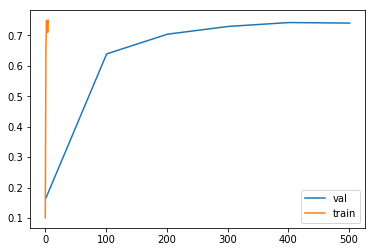

In [53]:
a, b = zip(*val_acc)
plt.plot(a,b, label='val')
plt.plot(train_acc, label='train')
plt.legend()
plt.show()

In [0]:
# model = ConvNetwork(train_dataset)
# model.net[0].weight.data.uniform_(-1,1)
# model.net[0].weight

a = torch.from_numpy(np.random.randn(3,10,1).astype(np.float32))

b = torch.exp(a)

z = a / b.sum(1, keepdim=True)

#indeces wanted from batches (i[0] says it wants the i[o] index from the first batch, and so on)
i = y_truth[:3]
row = torch.arange(b.size(0)) # tensor([0, 1, 2]
col = i # tensor([3, 2, 4]
b[row, col].mean()



# # first batch
# print(b[0])

# # first index of each batch
# print(b[:,0])


tensor([[0.3060],
        [0.6013],
        [2.6325],
        [1.4179],
        [0.9850],
        [7.1304],
        [1.7246],
        [0.8546],
        [0.6553],
        [0.2452]])
tensor([[0.3060],
        [0.2126],
        [0.3982]])


(tensor([0, 1, 2]), tensor([3, 2, 4], device='cuda:0'))


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**
* Experiment with Deep Networks
* Plot accuracy of training and validation set over time
* Print out number of parameters in the model 

**DONE:**


In [0]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [0]:
# Compute and print the number of parameters in the model

num_params = sum(p.numel() for p in model.parameters())
num_params

334425

___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3,3), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3,3), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3,3), padding=(6, 6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 5), padding=(1, 1))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5,5), padding=(2, 2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5,5), padding=(3, 3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5,5), padding=(9, 9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5,3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5,3), padding=(2,1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5,3), padding=(3, 2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5,3), padding=(9, 8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernel_size=(2,4), padding=(0, 0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(1,1), padding=(0, 0))**

**TODO:**

* Answer all the questions above 

**DONE:**

* Answer all the questions above 


In [13]:
# output_dim = input_dim - kernel_size + 1

# O = ((I - K + 2P) / s) + 1
# output = ((input_dim - kernel_size + 2*padding) / stride) + 1


# Write some test code for checking the answers for these problems (example shown in the video)
#Example
c = nn.Conv2d(3, 10, kernel_size=(3,3), padding=(0,0))
print(c(torch.zeros(1, 3, 10, 10)).size(), end="\n\n")


# 3x3 kernels
c = nn.Conv2d(3, 22, kernel_size=(3,3), padding=(1,1))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 65, kernel_size=(3,3), padding=(2,2))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 7, kernel_size=(3,3), padding=(6,6))
print(c(torch.zeros(1, 3, 10, 10)).size(), end="\n\n")


# 5x5 kernels
c = nn.Conv2d(3, 10, kernel_size=(5,5), padding=(1,1))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 100, kernel_size=(5,5), padding=(2,2))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 23, kernel_size=(5,5), padding=(3,3))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 5, kernel_size=(5,5), padding=(9,9))
print(c(torch.zeros(1, 3, 10, 10)).size(), end="\n\n")


# 5x3 kernels
c = nn.Conv2d(3, 10, kernel_size=(5,3), padding=(1,0))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 100, kernel_size=(5,3), padding=(2,1))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 23, kernel_size=(5,3), padding=(3,2))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 5, kernel_size=(5,3), padding=(9,8))
print(c(torch.zeros(1, 3, 10, 10)).size(), end="\n\n")


# Smallest padding size
c = nn.Conv2d(3, 10, kernel_size=(2,4), padding=(0,0))
print(c(torch.zeros(1, 3, 10, 10)).size())

c = nn.Conv2d(3, 22, kernel_size=(1,1), padding=(0,0))
print(c(torch.zeros(1, 3, 10, 10)).size(), end="\n\n")

torch.Size([1, 10, 8, 8])

torch.Size([1, 22, 10, 10])
torch.Size([1, 65, 12, 12])
torch.Size([1, 7, 20, 20])

torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])

torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])

torch.Size([1, 10, 9, 7])
torch.Size([1, 22, 10, 10])

